URL : https://www.kaggle.com/jagangupta/time-series-basics-exploring-traditional-ts

### Basics of TS :
Collation of different basic concepts of the different traditional time-series models and some basic intuition behind them<br>
### Objective :
This kernel was made to serve as a repository of various time-series concepts for beginners and I hope it would be useful as a refresher to some of the experts too.

### Table of contents :
* Competition and data overview
* Imports (data and packages)
* Basic exploration / EDA
* Single time-series
 * Stationarity
 * Seasonality, Trend and Remainder
 * AR, MR, ARMA, ARIMA
 * Selecting P and Q using AIC
 * ETS
 * Prophet
 * UCM
* Hierarchical time-series
 * Bottom's up
 * AHP
 * PHA
 * FP

### Competition and data overview :
In this playground competition, we are provided with the challenge of predicting total sales for every product and store in the next month for Russian Software company

<b>What does the IC company do?:</b><br>
1C: Enterprise 8 system of programes is intended for automation of everyday enterprise activities: various business tasks of economic and management activity, such as management accounting, business accounting, HR manegement, CRM, SRM, MRP, etc.<br><br>
<b>Data</b> : We are provided with daily sales data for each store-item combination, but our task is to predict sales at a monthly level.<br>

### Imports :

In [2]:
# Basic packages
import numpy as np
import pandas as pd
import random as rd
import datetime

# Viz
import matplotlib.pyplot as plt
import seaborn as sns

# Time Series
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

# settings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Import all of them 
sales = pd.read_csv('./input/sales_train_v2.csv')
item_cat = pd.read_csv('./input/item_categories.csv')
item = pd.read_csv('./input/items.csv')
sub = pd.read_csv('./input/sample_submission.csv')
shops = pd.read_csv('./input/shops.csv')
test = pd.read_csv('./input/test.csv')

In [6]:
#formatting the date column correctly
sales.date = pd.DatetimeIndex(pd.to_datetime(sales['date']))

In [7]:
# check
print(sales.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              datetime64[ns]
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB
None


In [8]:
# Aggregate to monthly level the required metrics

monthly_sales = sales.groupby(["date_block_num","shop_id","item_id"])["date","item_price","item_cnt_day"].agg({"date":["min",'max'],"item_price":"mean","item_cnt_day":"sum"})

## Lets break down the line of code here:
# aggregate by date-block(month),shop_id and item_id
# select the columns date, item_price and item_cnt(sales)
# Provide a dictionary which says what aggregation to perform on which column
# min and max on the date
# average of the item_price
# sum of the sales

In [9]:
# take a peak
monthly_sales.head(20)

date            item_price item_cnt_day
                                      min        max       mean          sum
date_block_num shop_id item_id                                              
0              0       32      2013-01-21 2013-03-01      221.0          6.0
                       33      2013-01-17 2013-03-01      347.0          3.0
                       35      2013-01-31 2013-01-31      247.0          1.0
                       43      2013-01-31 2013-01-31      221.0          1.0
                       51      2013-01-13 2013-01-31      128.5          2.0
                       61      2013-10-01 2013-10-01      195.0          1.0
                       75      2013-01-17 2013-01-17       76.0          1.0
                       88      2013-01-16 2013-01-16       76.0          1.0
                       95      2013-06-01 2013-06-01      193.0          1.0
                       96      2013-10-01 2013-10-01       70.0          1.0
                       98      2013-01-13 2013-12-01      268.0         25.0
                       111     2013-01-17 2013-01-17       89.0          1.0
                       149     2013-01-17 2013-11-01       99.0          3.0
                       151     2013-01-16 2013-01-16       75.0          1.0
                       153     2013-09-01 2013-09-01      258.0          1.0
                       198     2013-10-01 2013-10-01      112.0          1.0
                       210     2013-01-25 2013-05-01      118.0          2.0
                       282     2013-04-01 2013-04-01      109.0          1.0
                       306     2013-01-22 2013-01-22       59.0          1.0
                       351     2013-01-21 2013-01-21       89.0          1.0

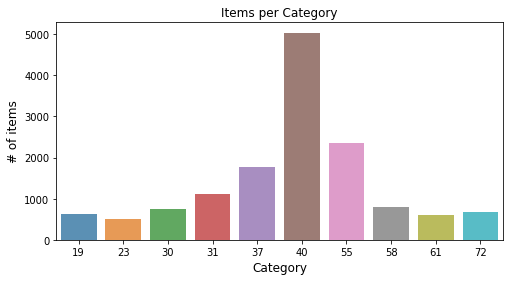

In [10]:
# number of items per cat 
x = item.groupby(['item_category_id']).count()
x = x.sort_values(by='item_id',ascending=False)
x = x.iloc[0:10].reset_index()

# #plot
plt.figure(figsize=(8,4))
ax = sns.barplot(x.item_category_id, x.item_id, alpha=0.8)
plt.title("Items per Category")
plt.ylabel('# of items', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.show()

Of sourse, there is a lot more that we can explore in this dataset, but let's dive into the time-series part.

### Single series :
The objective requires us to predict sales for the next month at a store-item combination.<br><br>
Sales over time of each store-item is a time-series in itself.<br>
Before we dive into all the combinations, first let's understand how to forecast for a single series.<br><br>
I've chosen to predict for the total slaes per month for the entire company.<br><br>
First let's compute the total sales per month and plot that data.

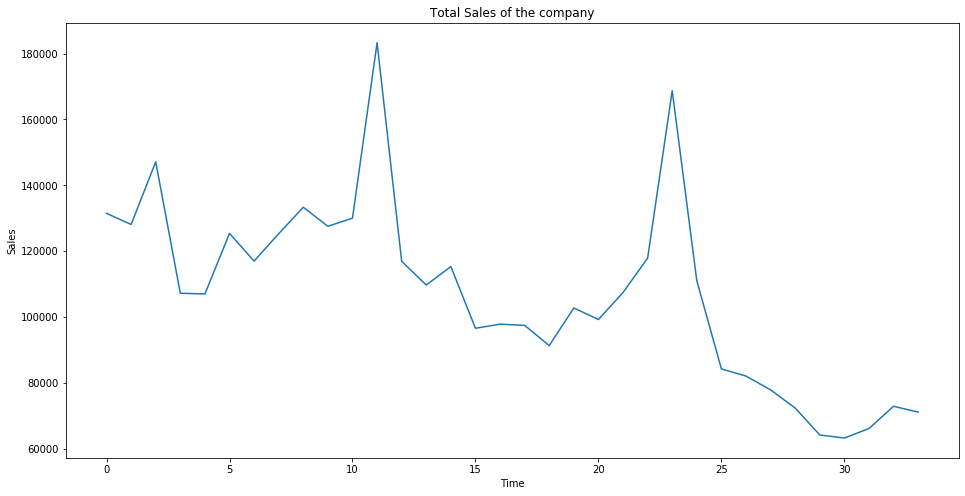

In [13]:
ts = sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('Total Sales of the company')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts)

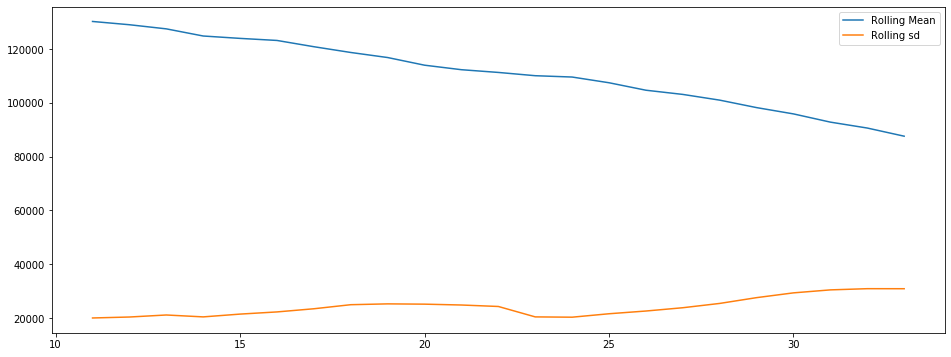

In [18]:
plt.figure(figsize=(16,6))
plt.plot(ts.rolling(window=12,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=12,center=False).std(),label='Rolling sd');
plt.legend();

<b> Quick observations :</b> There is an obvious "seasonality" (Eg: peak sales around a time of year) and a decreasing "Trend".<br><br>
Let's check that with a quick decomposition into Trend, seasonality and residuals.

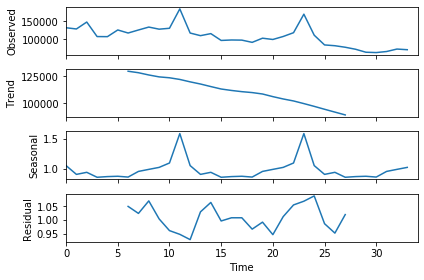

In [19]:
import statsmodels.api as sm
# multiplicative
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="multiplicative")
#plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()

we assume an additive model, then we can write
> yt=St+Tt+Et

where yt is the data at period t,St is the seasonal component at period t, Tt is the trend-cycle component at peroid tt and Et is the remainder (or irregular or error) component at period t Similarly for Multiplicative mode,
> yt=St x Tt x Et


### Stationarity :
![](./image1.png)
Stationarity refers to the time-invariance of a series. (ie) Two points in a time series are related to each other by only how far apart they are, and not by the direction(forward/backward)<br><br>
When a time series is stationary, it can be easier to model.<br>
Statistical modeling methods assume or require the time series to be stationary.<br><br>
There are multiple tests that can be used to check stationarity.
* ADF(Augmented Dicky Fuller Test)
* KPSS
* PP(Phillips-Perron test)
Let's just perform the ADF which is the most commonly used one.

In [20]:
# Stationarity tests
def test_stationarity(timeseries):
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statistic                 -2.395704
p-value                         0.142953
#Lags Used                      0.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64


In [21]:
# to remove trend
from pandas import Series as Series

# create a differenced series
def difference(dataset, interval = 1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced forecast
def inverse_difference(last_ob, value):
    return value + last_ob

[]

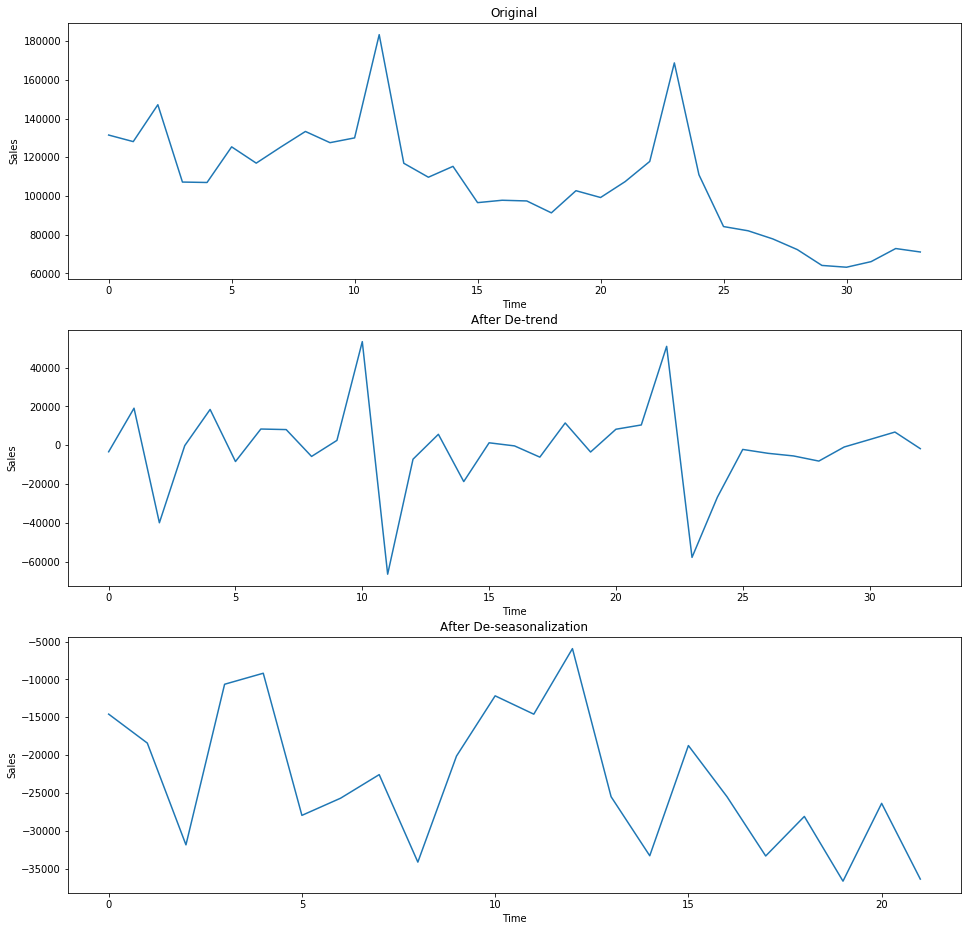

In [26]:
ts = sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,16))
plt.subplot(311)
plt.title('Original')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts)
plt.subplot(312)
plt.title('After De-trend')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts = difference(ts)
plt.plot(new_ts)
plt.plot()

plt.subplot(313)
plt.title('After De-seasonalization')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts = difference(ts,12) # assuming the seasonality is 12 months long
plt.plot(new_ts)
plt.plot()

In [27]:
# now testing the stationarity again after de-seasonality
test_stationarity(new_ts)

Results of Dickey-Fuller Test:
Test Statistic                 -3.270101
p-value                         0.016269
#Lags Used                      0.000000
Number of Observations Used    21.000000
Critical Value (1%)            -3.788386
Critical Value (5%)            -3.013098
Critical Value (10%)           -2.646397
dtype: float64


<b>
Now after the transformations, our p-value for the DF test is well within 5%.<br>
Hence we can assume Stationarity of the series<br>
</b>
We can easily get back the original series using the inverse transform function that we have defined above.<br><br>
Now let's dive into marking the forecasts!

### AR, MA and ARMA models :
TL : DR version of the models :<br><br>
MA - Next value in the series is a function of the average of the previous n number of values<br>
AR - The errors(difference in mean) of the next value is a function of the errors in the previous n number of values<br>
ARMA - a mixture of both.<br><br>
Now, How do we find out, if our time-series in AR process or MA process?<br><br>
Let's find out!

In [28]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh',title=''):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

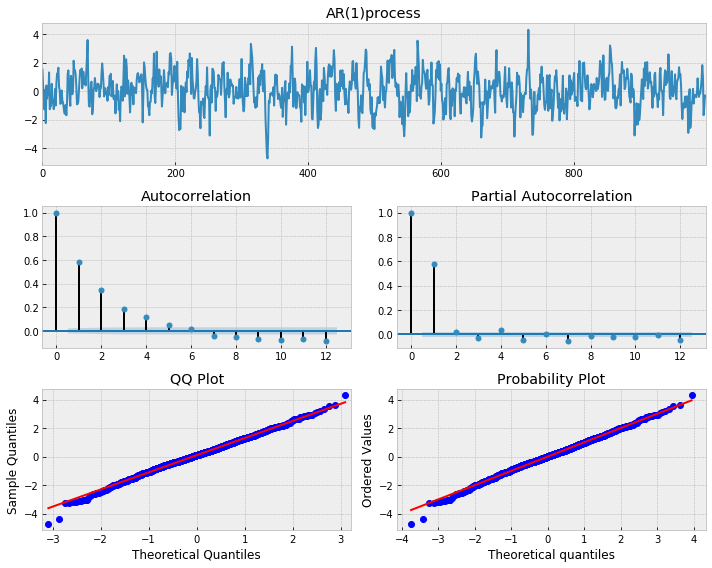

In [29]:
# Simulate an AR(1) process with alpha = 0.6
np.random.seed(1)
n_samples = int(1000)
a = 0.6
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]
limit=12    
_ = tsplot(x, lags=limit,title="AR(1)process")

### AR(1) process -- has ACF tailing out and PACF cutting off at lag=1

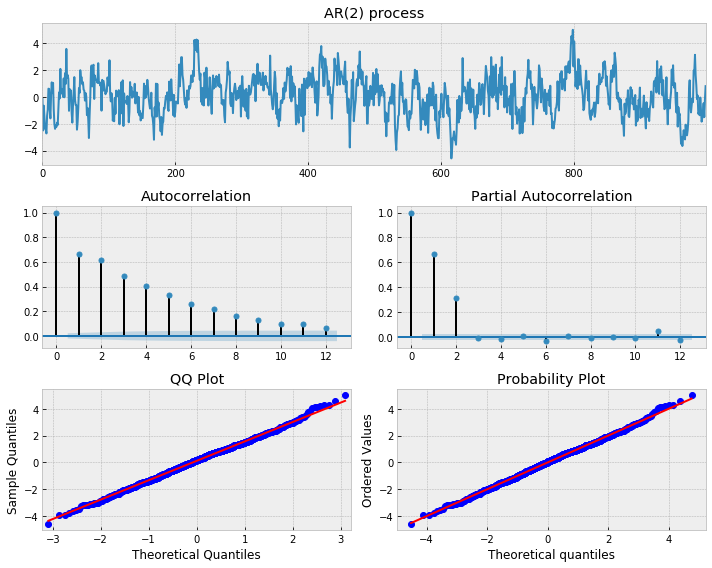

In [30]:
# Simulate an AR(2) process

n = int(1000)
alphas = np.array([.444, .333])
betas = np.array([0.])

# Python requires us to specify the zero-lag value which is 1
# Also note that the alphas for the AR model must be negated
# We also set the betas for the MA equal to 0 for an AR(p) model
# For more information see the examples at statsmodels.org
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ar2 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
_ = tsplot(ar2, lags=12,title="AR(2) process")

### AR(2) process -- has ACF tailing out and PACF cutting off at lag=2

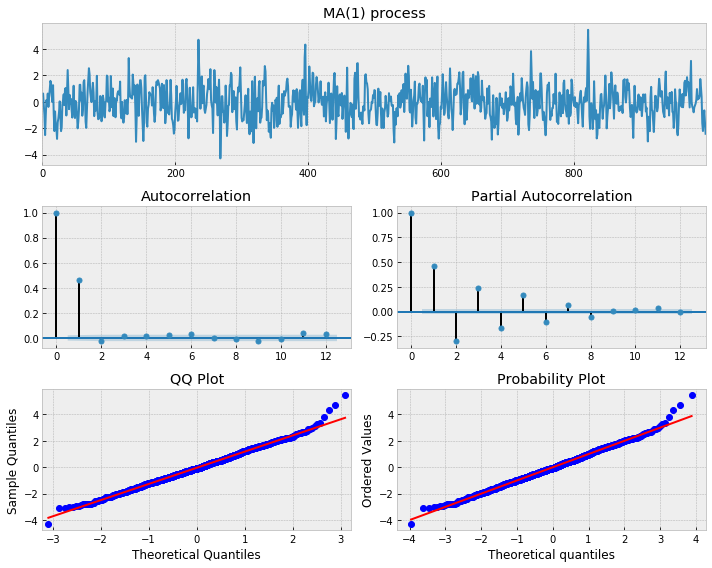

In [31]:
# Simulate an MA(1) process
n = int(1000)
# set the AR(p) alphas equal to 0
alphas = np.array([0.])
betas = np.array([0.8])
# add zero-lag and negate alphas
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]
ma1 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
limit=12
_ = tsplot(ma1, lags=limit,title="MA(1) process")

### MA(1) process -- has ACF cut off at lag=1

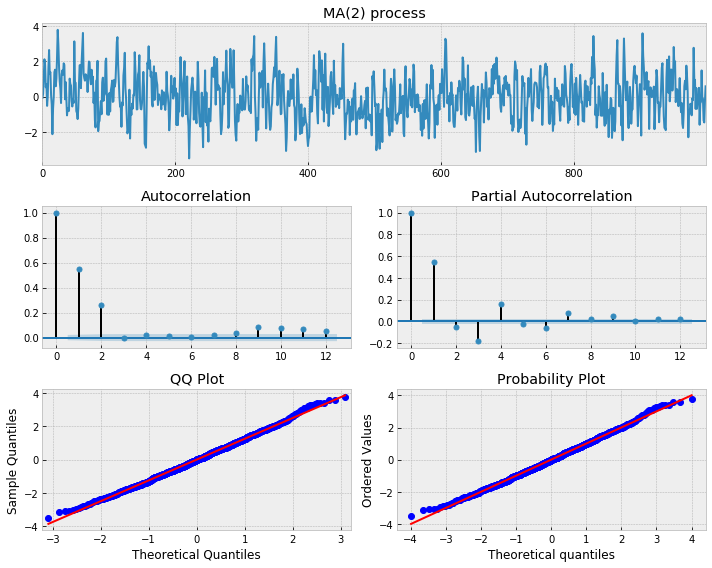

In [32]:
# Simulate MA(2) process with betas 0.6, 0.4
n = int(1000)
alphas = np.array([0.])
betas = np.array([0.6, 0.4])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ma3 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)
_ = tsplot(ma3, lags=12,title="MA(2) process")

### MA(2) process -- has ACF cut off at lag=2

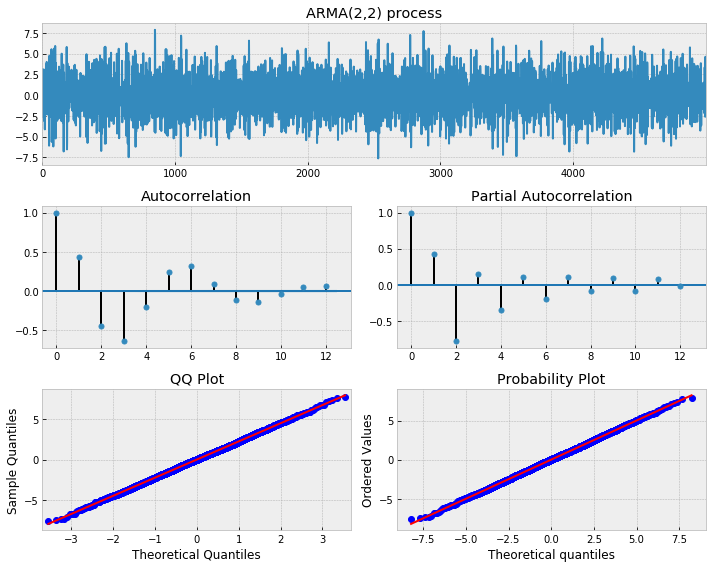

In [33]:
# Simulate an ARMA(2, 2) model with alphas=[0.5,-0.25] and betas=[0.5,-0.3]
max_lag = 12

n = int(5000) # lots of samples to help estimates
burn = int(n/10) # number of samples to discard before fit

alphas = np.array([0.8, -0.65])
betas = np.array([0.5, -0.7])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma22 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
_ = tsplot(arma22, lags=max_lag,title="ARMA(2,2) process")

### Now things get a little hazy. It's not very clear/straight-forward.
A nifty summary of the above plots:<br>

| ACF Shape | Indicated Model |
|---|---|
| Exponential, decaying to zero | Autoregressive model. Use the partial autocorrelation plot to identify the order of the auturegressive model |
| Alternating positive and negative, decaying to zero Autoregressive model. | Use the partial autocorrelation plot to help identify the order. |
| One or more spikes, rest are essentially zero | Moving average model, order identified by where plot becomes zero. |
| Decay, starting after a few lags | Mixed autoregressive and moving average (ARMA) model. |
| All zero or close to zero | Data are essentially random. |
| High values at fixed intervals | Include seasonal autoregressive term. |
| No decay to zero | Series is not stationary |

### Let's use a systematic approach to finding the order of AR and MA processes.

In [34]:
# pick best order by aic 
# smallest aic value wins
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(arma22, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: 15326.68109 | order: (2, 2)


### We've correctly identified the order of the simulated process as ARMA(2,2).

In [35]:
# pick best order by aic 
# smallest aic value wins
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(new_ts.values, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: 472.99703 | order: (1, 1)


In [36]:
# adding the dates to the Time-series as index
ts = sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.index = pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')
ts = ts.reset_index()
ts.head()

,index,item_cnt_day
0,2013-01-01,131479.0
1,2013-02-01,128090.0
2,2013-03-01,147142.0
3,2013-04-01,107190.0
4,2013-05-01,106970.0


### Prophet :
Recently open-sourced By Facebook research. It's a very promising tool, that is often a very handy and quick solution to the frustrating flatline.
![](./image2.jpg)

Sure, one could argue that with proper pre-processing and carefully tuning the parameters the above graph would not happen.

But the truth is that most of us don't either have the patience or the expertise to make it happen.

Also, there is the fact that in most practical scenarios- there is often a lot of time-series that needs to be predicted. Eg: This competition. It requires us to predict the next month sales for the Store - item level combinations which could be in the thousands.(ie) predict 1000s of parameters!

Another neat functionality is that it follows the typical sklearn syntax.

At its core, the Prophet procedure is an additive regression model with four main components:

* A piecewise linear or logistic growth curve trend. Prophet automatically detects changes in trends by selecting changepoints from the data.
* A yearly seasonal component modeled using Fourier series.
* A weekly seasonal component using dummy variables.
* A user-provided list of important holidays.

In [39]:
from fbprophet import Prophet
#prophet reqiures a pandas df at the below config 
# ( date column named as DS and the value column as Y)
ts.columns=['ds','y']
model = Prophet(yearly_seasonality=True) #instantiate Prophet with only yearly seasonality as our data is monthly 
model.fit(ts) #fit the model with your dataframe

ModuleNotFoundError: No module named 'fbprophet'